In [1]:
import pandas as pd # for dataframe
import joblib # for save model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import acf, q_stat, adfuller  
from scipy.stats import probplot, moment
import joblib
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [3]:
# call data
df_season = joblib.load("D:/BOOTCAMP/project/Project Pribadi/Udemy - Time Series Analysis in Python/data/data feature/df_season.csv")
df = joblib.load("D:/BOOTCAMP/project/Project Pribadi/Udemy - Time Series Analysis in Python/data/data feature/df_time.csv")
df_price = joblib.load("D:/BOOTCAMP/project/Project Pribadi/Udemy - Time Series Analysis in Python/data/data feature/df_price.csv")
df_copy = joblib.load("D:/BOOTCAMP/project/Project Pribadi/Udemy - Time Series Analysis in Python/data/data feature/df_time.csv")

In [4]:
# drop data avg price in data df because in df_price is stationar
df = df.drop('AveragePrice', axis=1)

In [5]:
# copy data avg price
df_price_copy = df_price.copy()

# drop index
df_price_copy = df_price_copy.loc[~df_price_copy.index.duplicated(keep='first')]

In [6]:
# concat data df_price and df
df_marge = pd.concat([df, df_price_copy],
                           axis = 1)

(df_marge.shape)

(18249, 4)

In [7]:
# df_copy : Data without Transform
# df_price : Data transform just avg price
# df_marge : Data concat data avg transform with other columns

# Splitting data

before continues, we must splitting data train and test for validation predict

<AxesSubplot:xlabel='Date'>

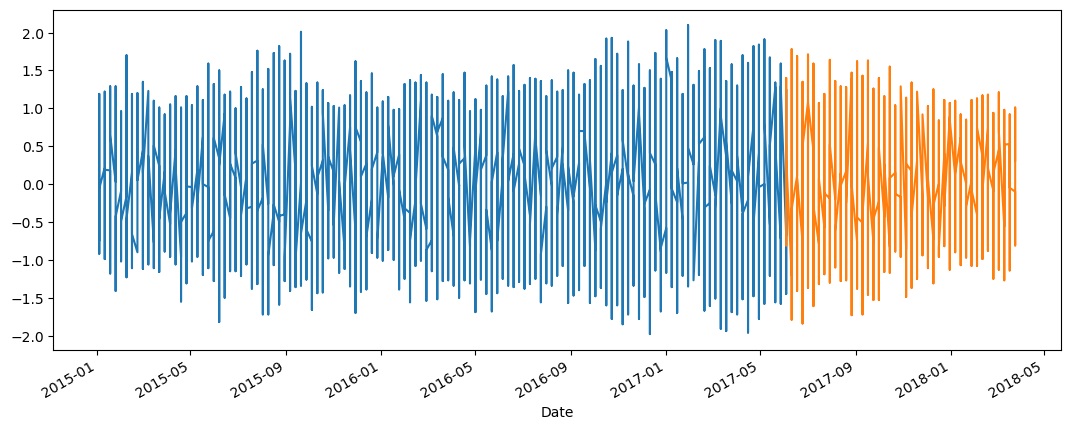

In [8]:
#divide into train and validation set
train_1 = df_season[:int(0.75*(len(df_season.AveragePrice)))]
test_1 = df_season[int(0.75*(len(df_season.AveragePrice))):]

#plotting the data
plt.figure(figsize=(13, 5))
train_1['AveragePrice'].plot()
test_1['AveragePrice'].plot()

<AxesSubplot:xlabel='Date'>

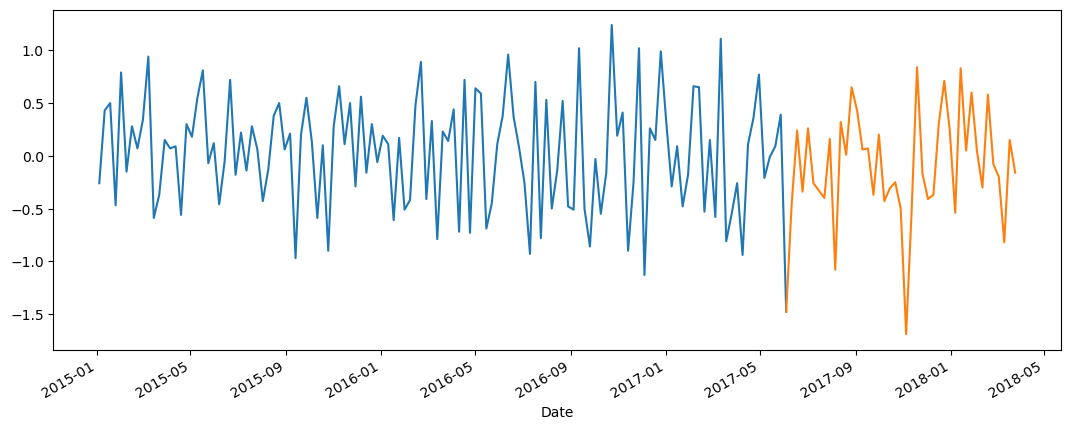

In [9]:
#divide into train and validation set
train_2 = df_marge[:int(0.75*(len(df_marge.AveragePrice)))]
test_2 = df_marge[int(0.75*(len(df_marge.AveragePrice))):]

#plotting the data
plt.figure(figsize=(13, 5))
train_2['AveragePrice'].plot()
test_2['AveragePrice'].plot()

<AxesSubplot:xlabel='Date'>

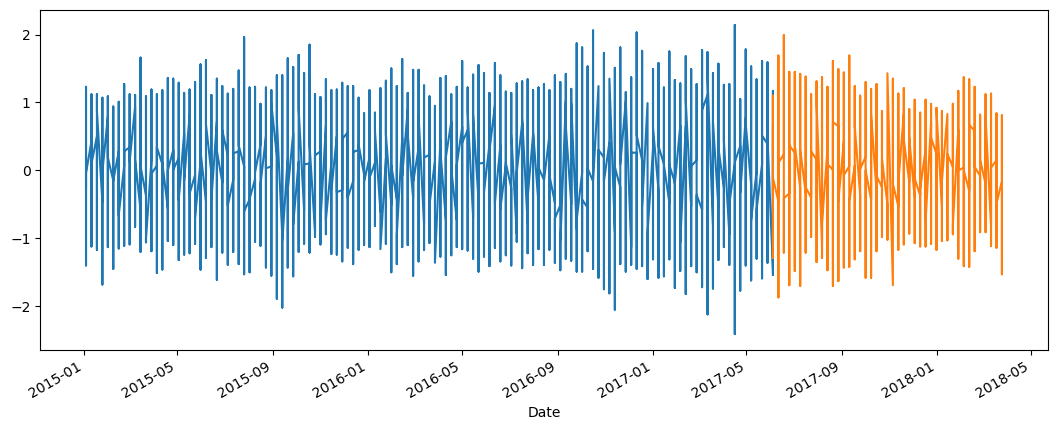

In [10]:
#divide into train and validation set
train = df_price[:int(0.75*(len(df_price)))]
test = df_price[int(0.75*(len(df_price))):]

#plotting the data
plt.figure(figsize=(13, 5))
train['AveragePrice'].plot()
test['AveragePrice'].plot()

# Model ARIMA

### Model (1) 

First we want forecasting just column avg price. Also we check this main column with auto_arima model, because with this model we know what is the best model and suitable

In [11]:
# make auto arima without X or not Arimax (x is add other columns)
model_auto = auto_arima(train[1:],m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)
model_auto

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 5),
      suppress_warnings=True, with_intercept=False)

In [12]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                13685
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -6268.691
Date:                Mon, 24 Apr 2023   AIC                          12545.381
Time:                        19:20:15   BIC                          12575.478
Sample:                             0   HQIC                         12555.412
                              - 13685                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0127      0.008      1.504      0.133      -0.004       0.029
ar.L2         -0.0186      0.009     -2.187      0.029      -0.035      -0.002
ma.L1         -0.9891      0.001   -777.265      0.000      -0.992      -0.987
sigma2         0.1463      0.002     85.006      0.000       0.143       0.150
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               765.27
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

we get ARIMA model for data price, now check predict

C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: 44.7542')

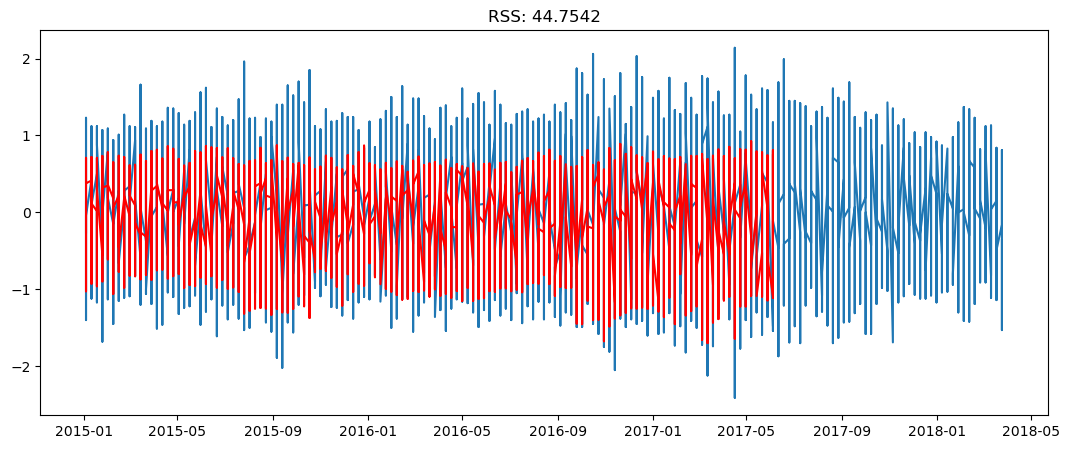

In [13]:
# Using the recommended model to see its output
model_arima = sm.tsa.statespace.SARIMAX(train, order=(2, 0, 1), seasonal_order=(0, 0, 0, 5))

# fit and predict forecasting
model_arima_fit = model_arima.fit(disp=False)

# plot fitt model for compare data real
plt.figure(figsize=(13, 5))
plt.plot(df_price)
plt.plot(model_arima_fit.fittedvalues[1:], color = 'red' )
plt.title('RSS: %.4f'% np.sqrt(abs(sum((model_arima_fit.fittedvalues-train['AveragePrice'])**2)))) #Calculate RSS value between our model and the

### Model (2) 

The resul from MAE is good model, now we want add ARIMAX >> X is columns returm total sold

In [14]:
# find best model
model_auto_2 = auto_arima(train_2.AveragePrice[1:], exogenous = train_2.Total_sold[1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)
model_auto_2

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
      suppress_warnings=True, with_intercept=False)

In [15]:
model_auto_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                13685
Model:               SARIMAX(0, 1, 0)   Log Likelihood               15208.119
Date:                Mon, 24 Apr 2023   AIC                         -30414.238
Time:                        19:20:58   BIC                         -30406.714
Sample:                             0   HQIC                        -30411.730
                              - 13685                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0063   6.56e-06    966.949      0.000       0.006       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          41970585.03
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.20   Skew:                            -2.76
Prob(H) (two-sided):                  0.00   Kurtosis:                       274.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: 9.3191')

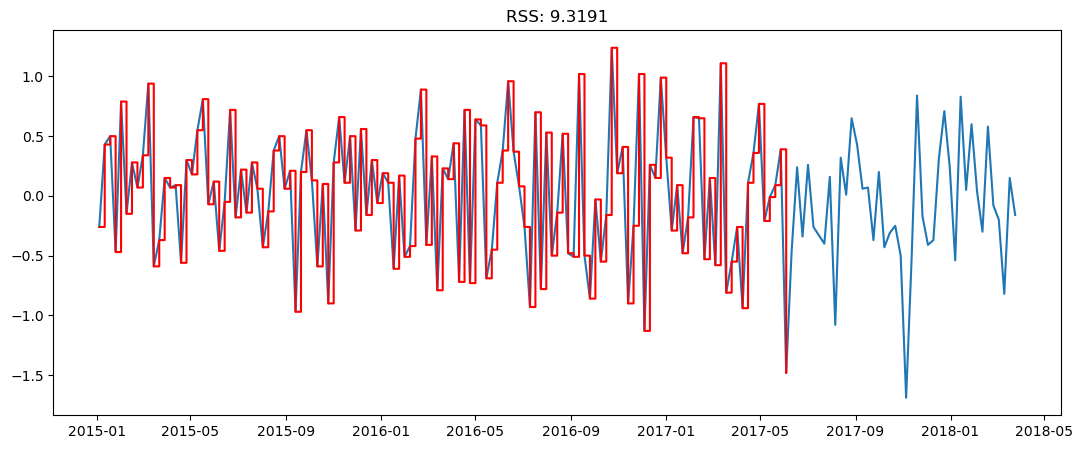

In [16]:
# Using the recommended model to see its output
model_arima = sm.tsa.statespace.SARIMAX(train_2.AveragePrice, order=(0, 1, 0), seasonal_order=(0, 0, 0, 5))

# fit and predict forecasting
model_arima_fit_2 = model_arima.fit(disp=False)

# plot fitt model for compare data real
plt.figure(figsize=(13, 5))
plt.plot(df_marge.AveragePrice)
plt.plot(model_arima_fit_2.fittedvalues[1:], color = 'red' )
plt.title('RSS: %.4f'% np.sqrt(abs(sum((model_arima_fit_2.fittedvalues-train_2['AveragePrice'])**2)))) #Calculate RSS value between our model and the

# Model (3)

Now we want use Auto - SARIMA : add season in the model

In [17]:
model = auto_arima(train_1.AveragePrice, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=6, stepwise=True)
model.fit(train_1.AveragePrice)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=inf, Time=28.86 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=21743.105, Time=1.12 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=21744.394, Time=1.33 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=21639.770, Time=2.91 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=21741.105, Time=0.54 sec
 ARIMA(0,0,1)(0,0,0)[6] intercept   : AIC=21742.946, Time=1.01 sec
 ARIMA(0,0,1)(1,0,1)[6] intercept   : AIC=inf, Time=11.37 sec
 ARIMA(0,0,1)(0,0,2)[6] intercept   : AIC=inf, Time=25.76 sec
 ARIMA(0,0,1)(1,0,0)[6] intercept   : AIC=21744.273, Time=1.73 sec
 ARIMA(0,0,1)(1,0,2)[6] intercept   : AIC=inf, Time=32.11 sec
 ARIMA(0,0,0)(0,0,1)[6] intercept   : AIC=21642.908, Time=1.90 sec
 ARIMA(1,0,1)(0,0,1)[6] intercept   : AIC=inf, Time=14.54 sec
 ARIMA(0,0,2)(0,0,1)[6] intercept   : AIC=21637.475, Time=3.48 sec
 ARIMA(0,0,2)(0,0,0)[6] intercept   : AIC=21734.372, Time=1.25 sec
 ARIMA(0,0,2)(1,0,1)[6] intercept   : AIC=in

ARIMA(order=(0, 0, 2), scoring_args={}, seasonal_order=(0, 0, 1, 6),
      suppress_warnings=True, with_intercept=False)

In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                13677
Model:             SARIMAX(0, 0, 2)x(0, 0, [1], 6)   Log Likelihood              -10813.737
Date:                             Mon, 24 Apr 2023   AIC                          21635.475
Time:                                     19:26:46   BIC                          21665.569
Sample:                                          0   HQIC                         21645.505
                                           - 13677                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0193      0.008      2.300      0.021       0.003       0.036
ma.L2         -0.0180      0.008     -2.125      0.034      -0.035      -0.001
ma.S.L6        0.7326      0.006    127.779      0.000       0.721       0.744
sigma2         0.2845      0.003     83.377      0.000       0.278       0.291
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                20.03
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: 62.6433')

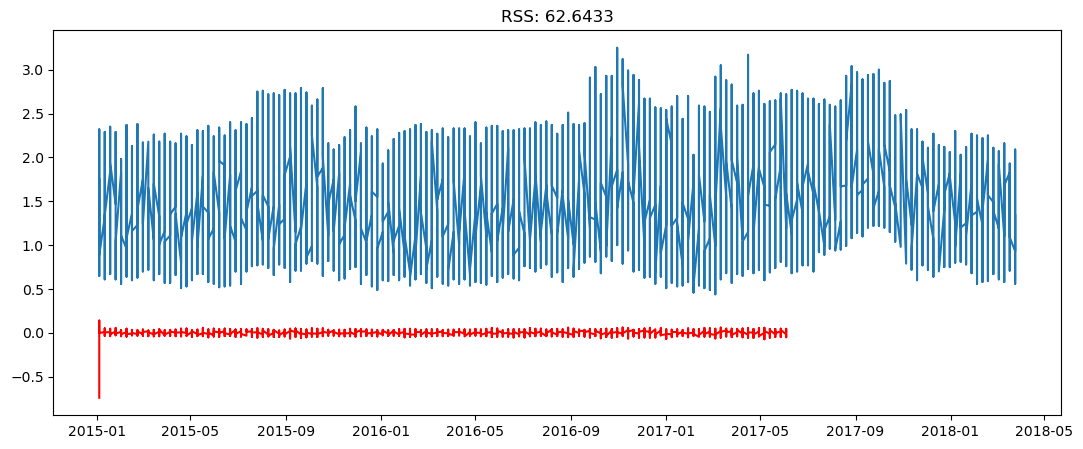

In [19]:
# predict best model from itertool method
model_arima_sar = sm.tsa.statespace.SARIMAX(train_1.AveragePrice, order=(0, 1, 3), seasonal_order=(1, 0, 0, 6))

# fit and predict forecasting
model_arima_fit_3 = model_arima_sar.fit(disp=False)

# plot fitt model for compare data real
plt.figure(figsize=(13, 5))
plt.plot(df_copy.AveragePrice)
plt.plot(model_arima_fit_3.fittedvalues[1:], color = 'red' )
plt.title('RSS: %.4f'% np.sqrt(abs(sum((model_arima_fit_3.fittedvalues-train_1['AveragePrice'])**2)))) #Calculate RSS value between our model and the

# Model (4)

In [20]:
p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q)) # Create an array that holds all different combinations of p, q and q
pdq_PDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal P, D and Q

In [21]:
pdq_PDQs # s paramter is 12 as we know our seasonality is 12 months (or rows) in our TS.

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [22]:
best_aic=np.inf # Set best AIC value to infinte. This will be replaced by smaller values obtained in our for loop.
best_mod = '' #Set empty value for our best model. This will be relpaced by models with better performing parameters.
for parameter in pdq:
    for seasonal_parameter in pdq_PDQs:
        try:
            modelS = sm.tsa.statespace.SARIMAX(train_1['AveragePrice'],
                                            order=parameter,
                                            seasonal_order=seasonal_parameter,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = modelS.fit()
            if results.aic < best_aic:
                best = results
                best_aic = results.aic
                best_order = parameter
                best_seasonal_order=seasonal_parameter
        except:
            continue
            
print('TOP SARIMA{}x{} - AIC:{}'.format(best_order, best_seasonal_order, best.aic)) #Print the parameters from our best model.

C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

TOP SARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:12615.68995711799


In [23]:
print(best.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       AveragePrice   No. Observations:                13677
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -6303.845
Date:                            Mon, 24 Apr 2023   AIC                          12615.690
Time:                                    19:41:40   BIC                          12645.779
Sample:                                         0   HQIC                         12625.719
                                          - 13677                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0129      0.008      1.523      0.128      -0.004       0.030
ma.L1         -1.0106      0.001   

Once the model has been fitted, we can check if does what we expect and if the assumptions we made are violated. To do this, we can use the method

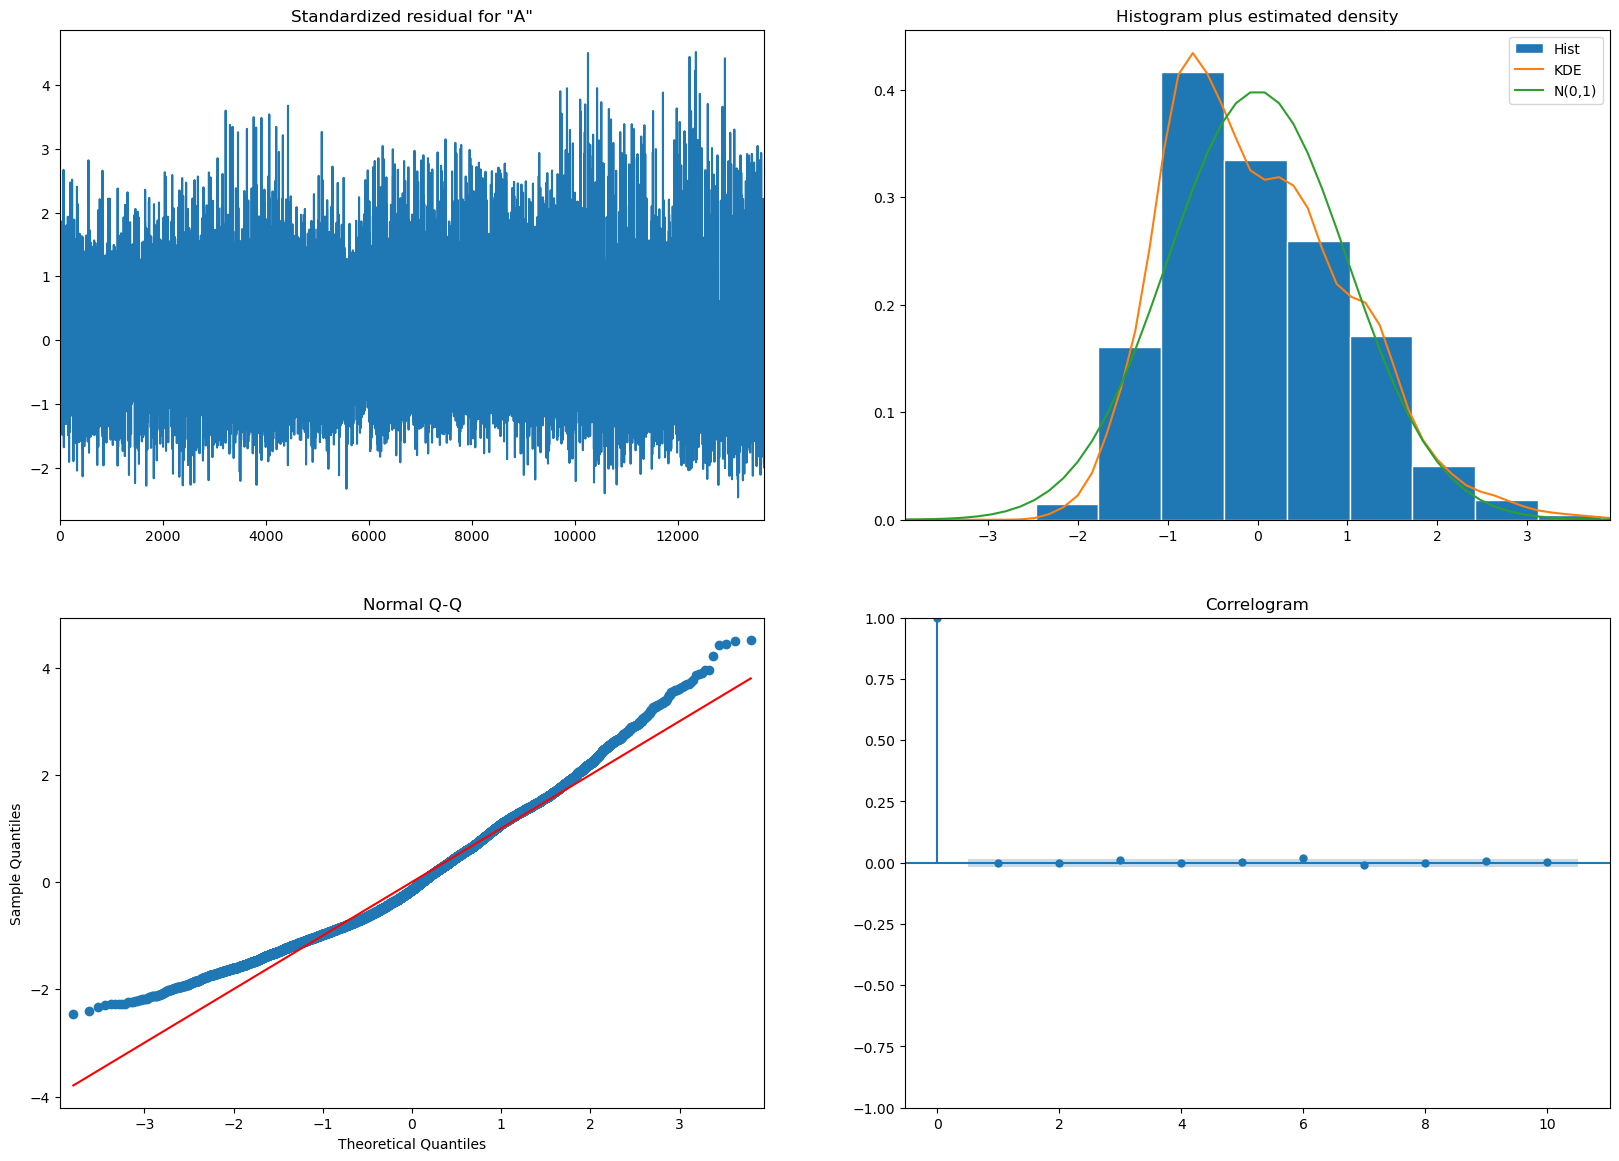

In [24]:
# model 1
model_arima_fit.plot_diagnostics(figsize=(20, 14))
plt.show()

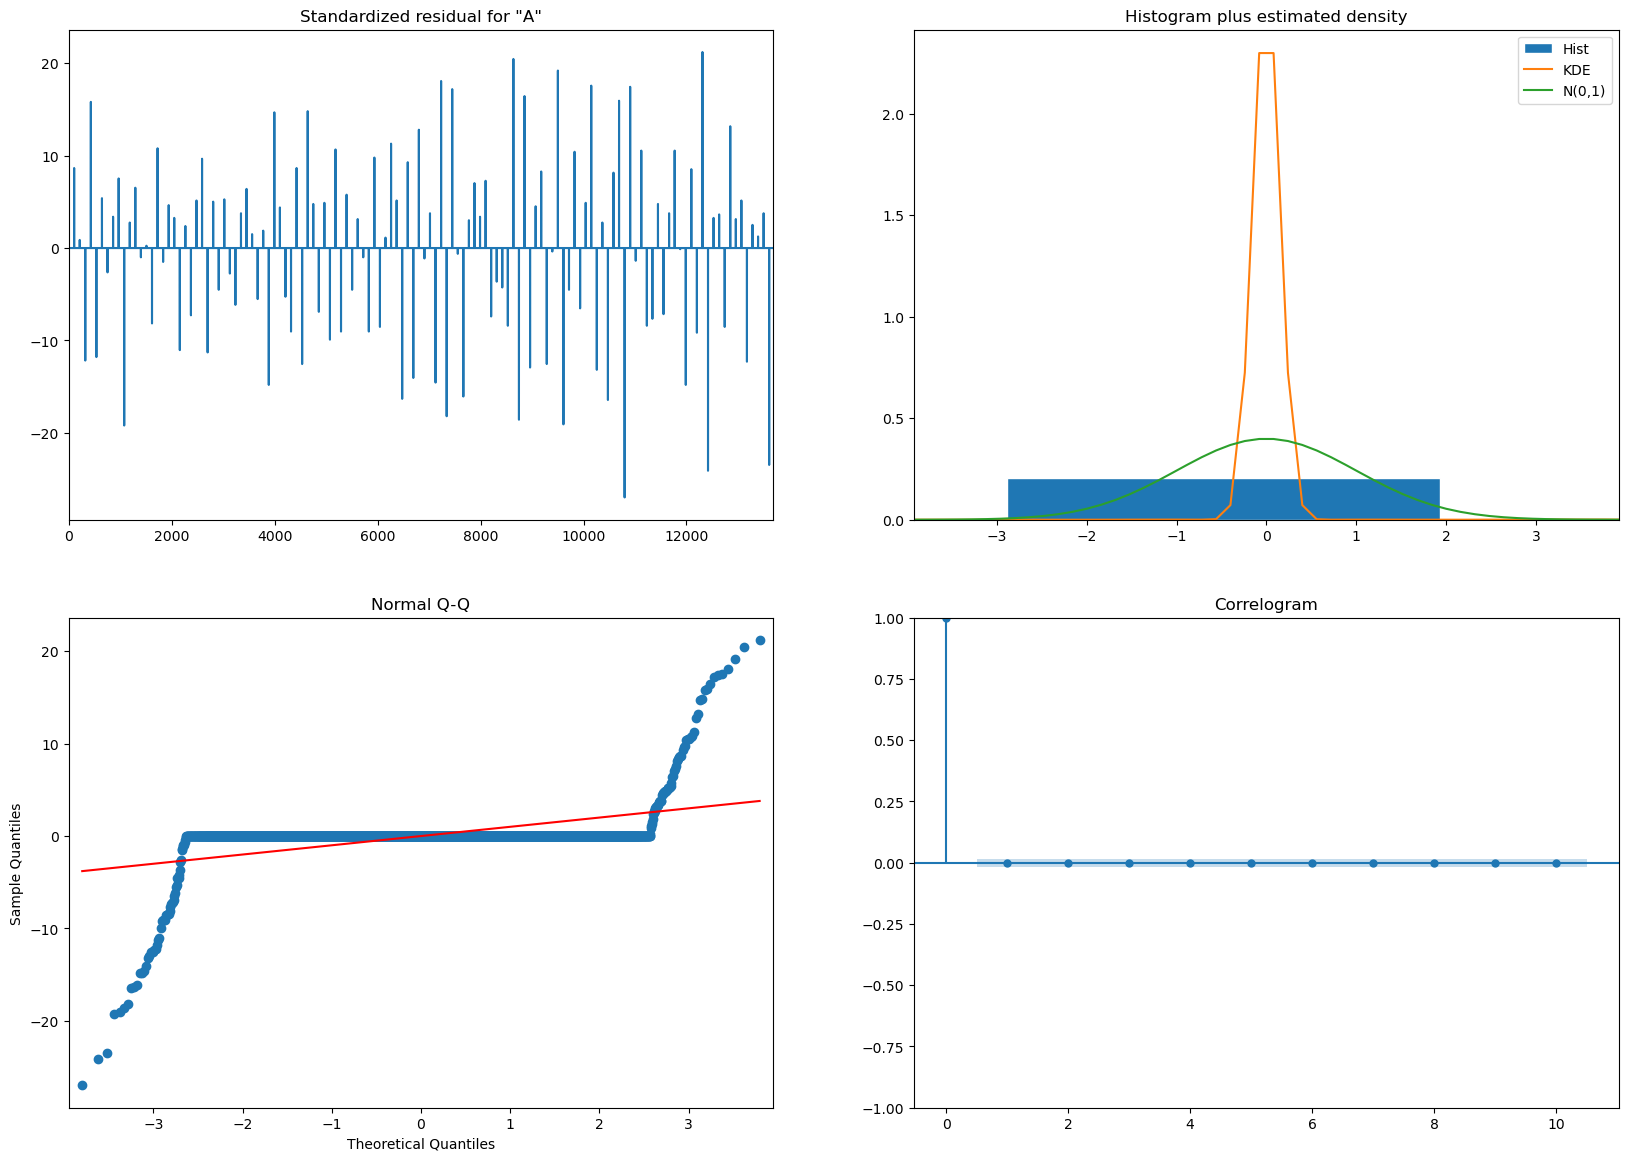

In [25]:
# model 2
model_arima_fit_2.plot_diagnostics(figsize=(20, 14))
plt.show()

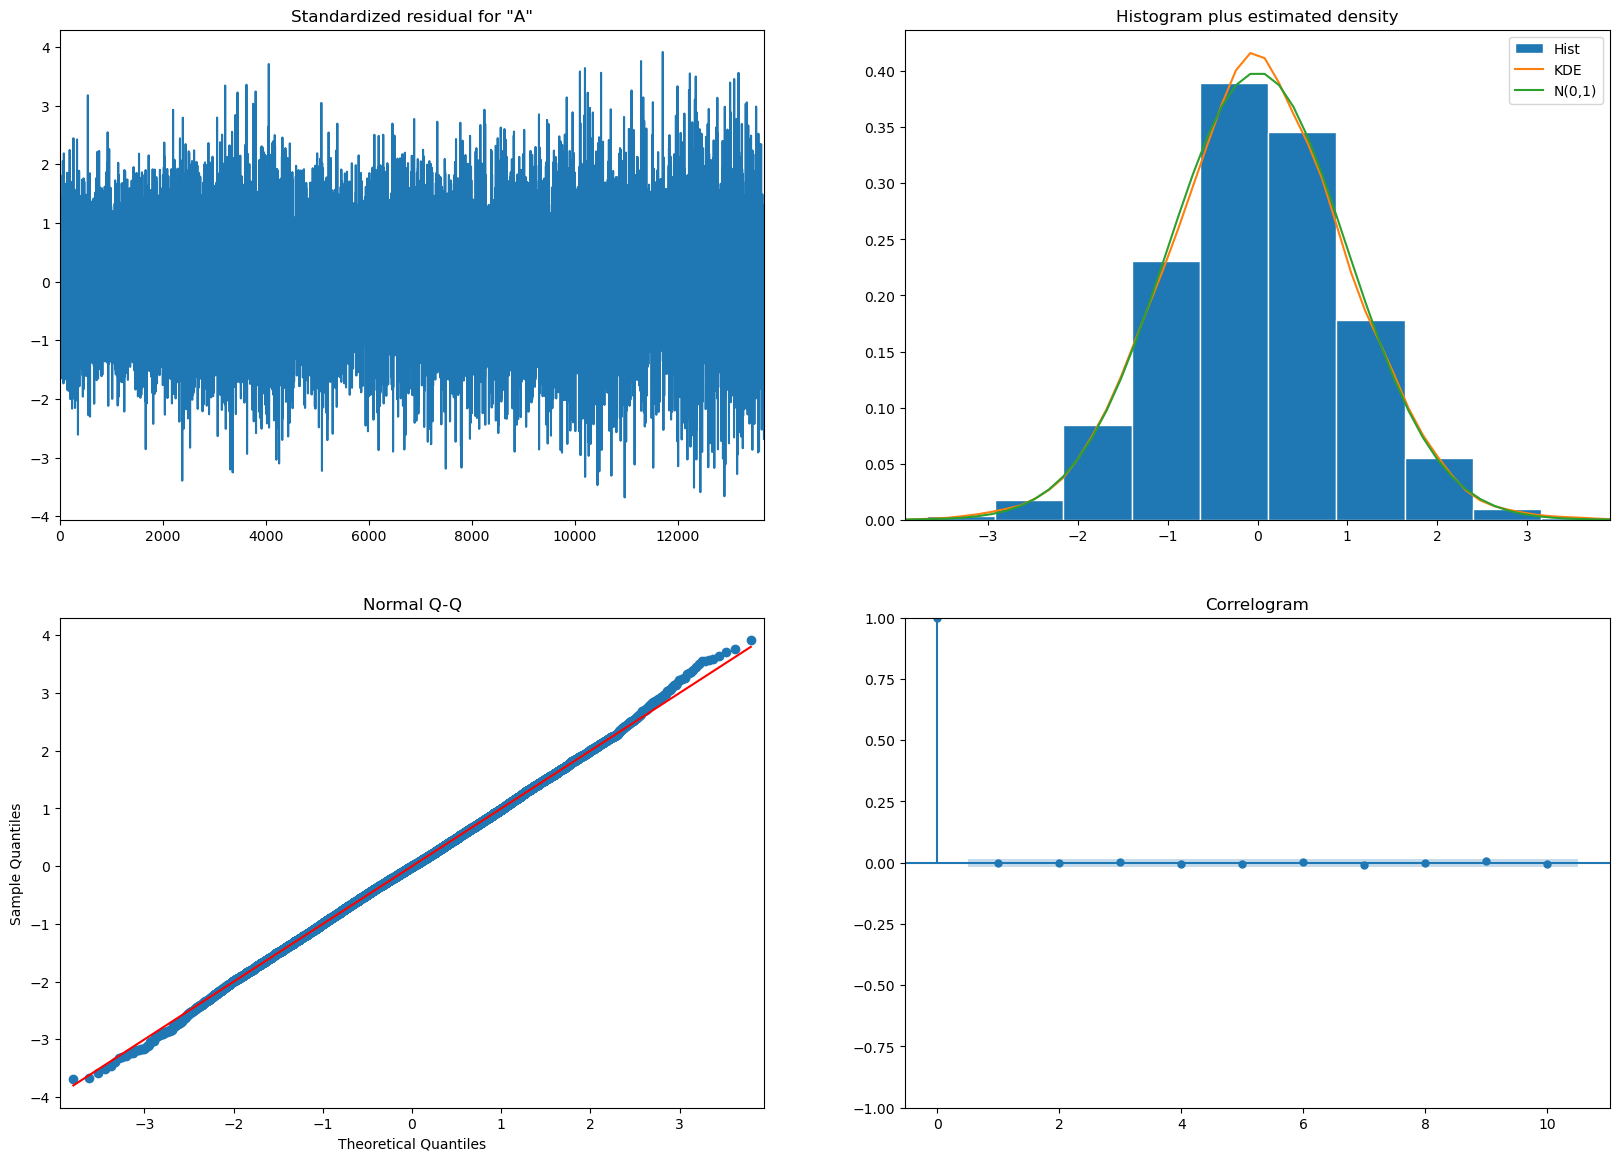

In [26]:
# model 3
model_arima_fit_3.plot_diagnostics(figsize=(20, 14))
plt.show()

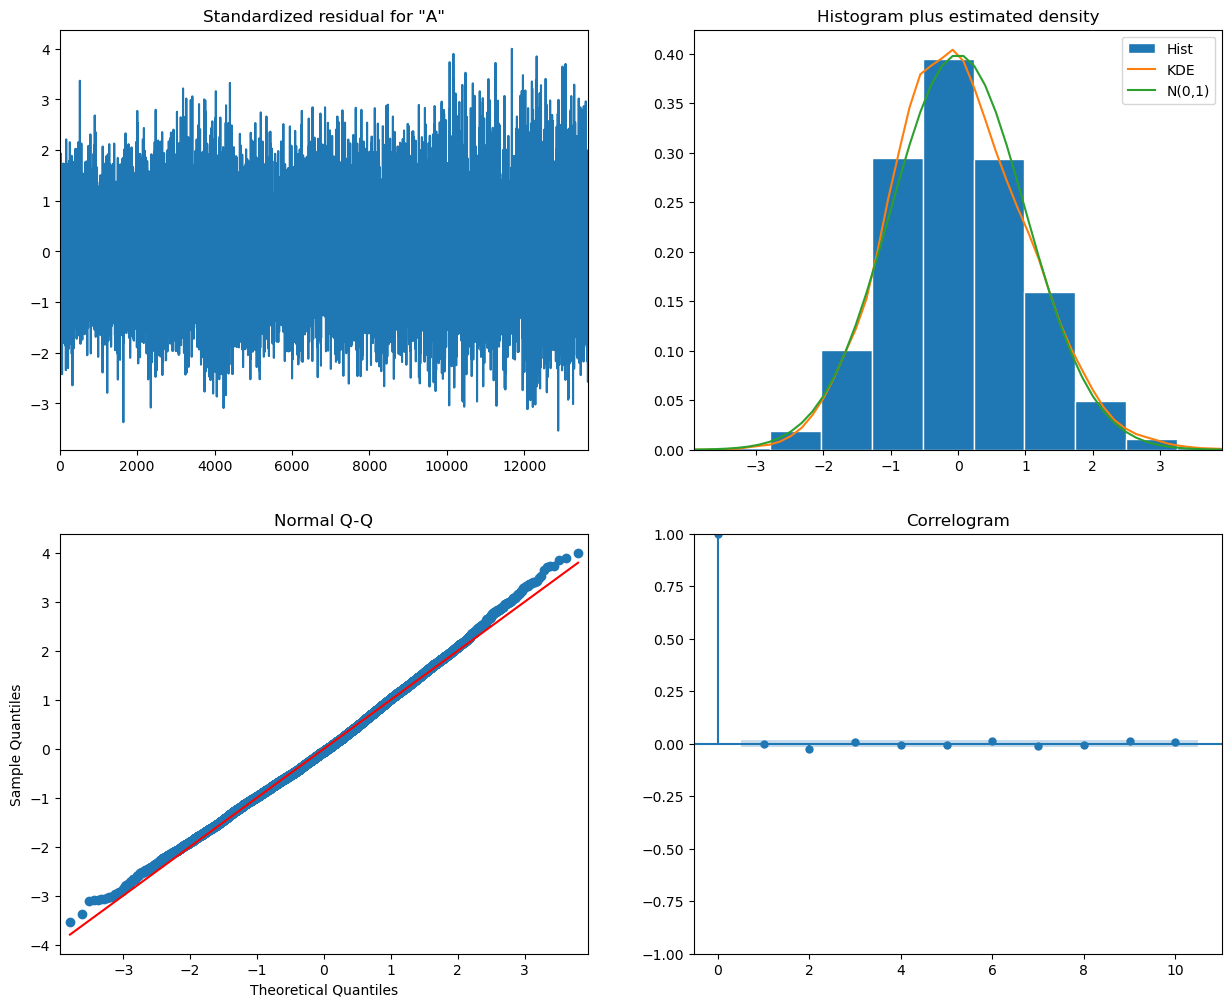

In [27]:
# model 4
results.plot_diagnostics(figsize=(15, 12))
plt.show()

We can see that this ARIMA model has performed good. from interpration in the on plot before, best plot and best fit model is model 3 or 4 because make histogram normal, normal QQ with residual close to the original value, and autocorrelation is stationar. Next we make prediction and check RMSE for this model

### Prediction 

In [43]:
# make predict
pred_1 = results.predict(start= len(train_1.AveragePrice), end=len(df_season)-1)
# Check RMSE
error = np.sqrt(mean_squared_error(test_1.AveragePrice,pred_1))
print(f'Result of RMSE is {error}')

C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Result of RMSE is 0.49450750836209534


In [35]:
forecast = results.predict(n_periods=len(test_1))

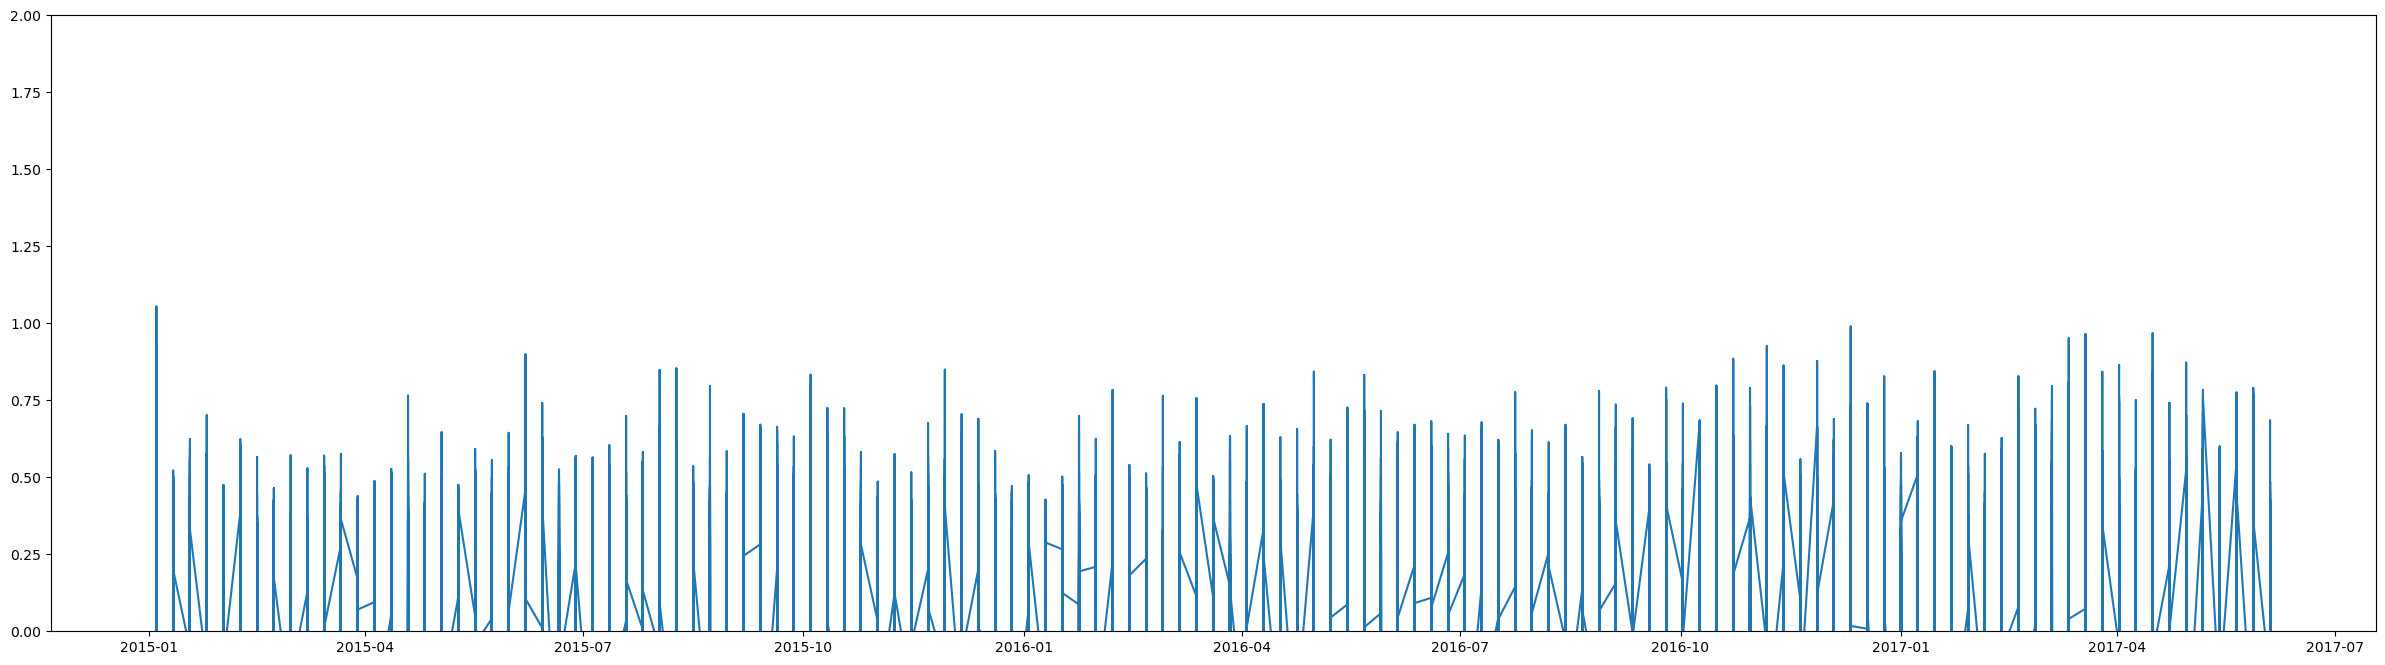

In [36]:
#plot the predictions for data test set
#plt.plot(df_copy.AveragePrice, label='Train')
plt.plot(forecast, label='Prediction')
plt.ylim(0, 2)
plt.show()

### Forecasting

Next Plotting our model and our forecasting, we can compare our model prediction vs our 'test' portion of the TS.

In [37]:
predict_full = results.get_prediction(start=15511,end=18248,dynamic= True)
pred_full_ci = predict_full.conf_int()
pred_full_ci.head()

C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


,lower AveragePrice,upper AveragePrice
15511,-1.050435,1.050992
15512,-1.050539,1.050888
15513,-1.050243,1.051184
15514,-1.050451,1.050976
15515,-1.050499,1.050929


Text(0, 0.5, 'Avg Price')

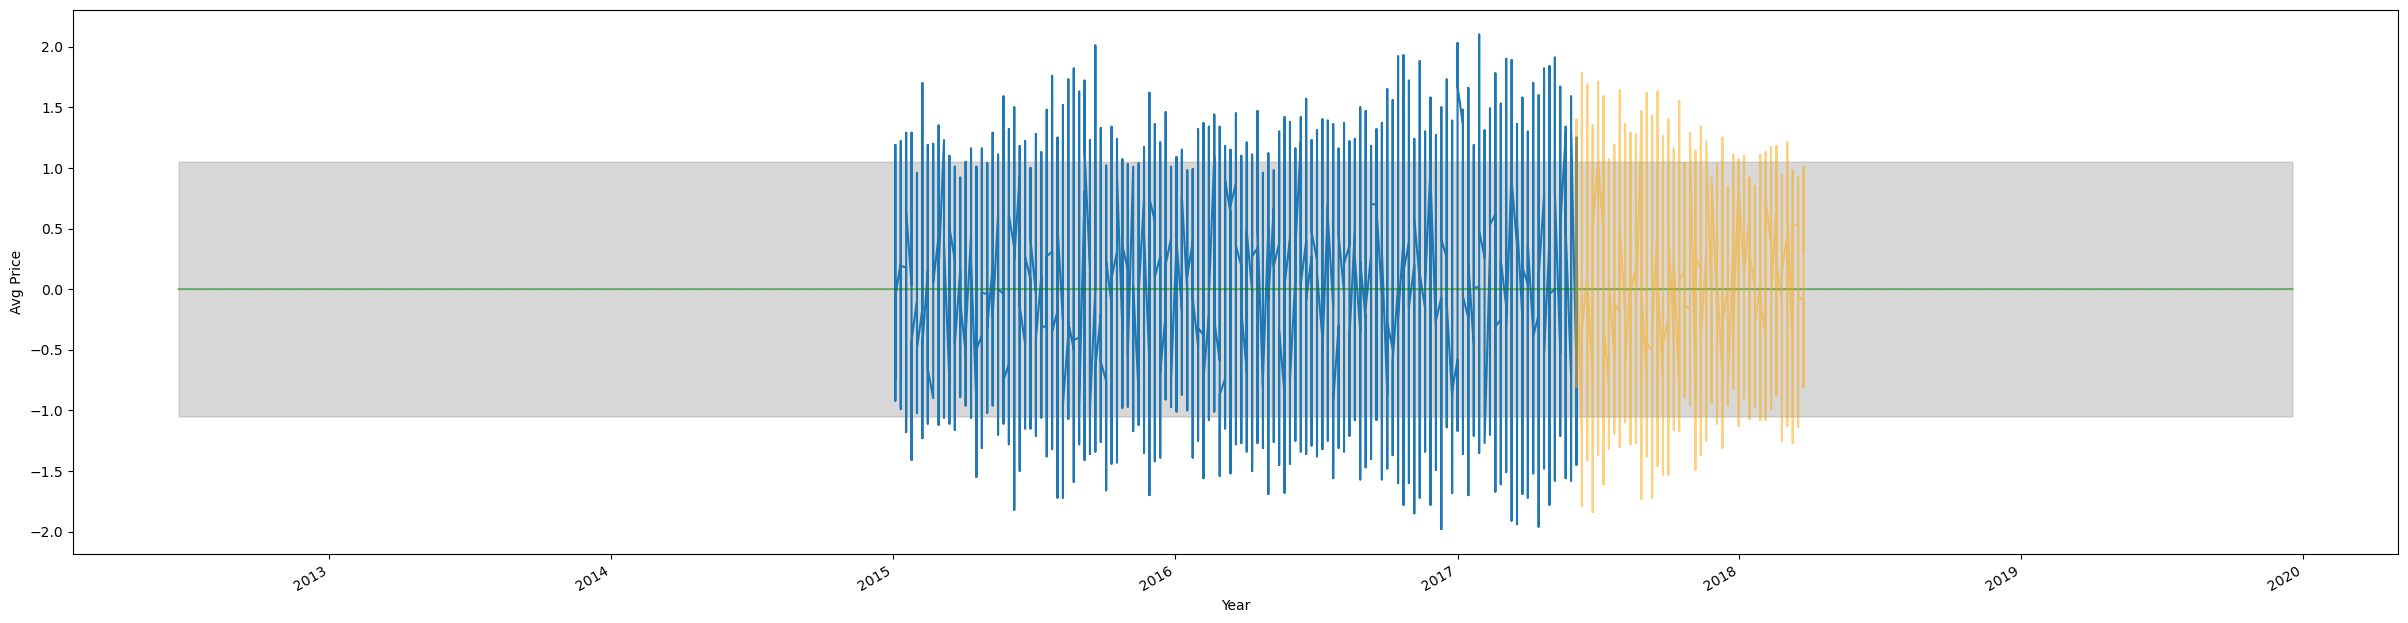

In [38]:
plt.rcParams["figure.figsize"] = [30,8]
ax = train_1.AveragePrice.plot(label='observed')
predict_full.predicted_mean.plot(ax=ax, label='Forecast', color='green',alpha=.5) # Predictied values are green
test_1.AveragePrice.plot(ax=ax, label='Test', alpha=.5, color = 'orange') # Test values are orange

ax.fill_between(pred_full_ci.index,
                pred_full_ci.iloc[:, 0],
                pred_full_ci.iloc[:, 1], color='grey', alpha=.3)

ax.set_xlabel('Year')
ax.set_ylabel('Avg Price')

In [41]:
# A few next years
predict_full = results.get_prediction(start=18248,end=20000,dynamic= True)
pred_full_ci = predict_full.conf_int()
pred_full_ci.head()

C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


,lower AveragePrice,upper AveragePrice
18248,-1.050569,1.050950
18249,-1.050274,1.051246
18250,-1.050482,1.051038
18251,-1.050529,1.050991
18252,-1.050674,1.050846


# Result

- In the next few years each period will experience an increase and decrease minus, while each increase is equal to 1.0.. price avocado